### ML Data Cleaning and Feature Selection

In this assignment, you will use a dataset for predictive learning and check the quality of the data and determine which features are important.

Answer the following questions:

 

* What are the data types? (Only numeric and categorical)

* Are there missing values?

* What are the likely distributions of the numeric variables?

* Which independent variables are useful to predict a target (dependent variable)? (Use at least three methods)

* Which independent variables have missing data? How much? 

* Do the training and test sets have the same data?

* In the predictor variables independent of all the other predictor variables?

* Which predictor variables are the most important?

* Do the ranges of the predictor variables make sense?

* What are the distributions of the predictor variables?   

* Remove outliers and keep outliers (does if have an effect of the final predictive model)?

* Remove 1%, 5%, and 10% of your data randomly and impute the values back using at least 3 imputation methods. How well did the methods recover the missing values?  That is remove some data, check the % error on residuals for numeric data and check for bias and variance of the error.

For categorical data, calculate the accuracy and a confusion matrix.

In [1]:
#installing dependencies
!pip install eli5


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
# Function to display exact values on barplots
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height() * 0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height() * 0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

# Function to display all the columns and rows
def set_pandas_display_options() -> None:
    display = pd.options.display
    display.max_columns = 50
    display.max_rows = 100
    display.max_colwidth = 100
    display.width = None

# Function to display distribution of feat by col (from list columns_cat)
def display_distributions(feat):
    for col in columns_cat:
        sns.displot(data=insurance, x=feat, hue=col,
                    height=4, aspect=2, kind='kde')

        plt.title(f'Distribution of {feat} by {col}', size=18)
        plt.xlabel(feat, size=14)
        plt.ylabel('Count', size=14)
        plt.xticks(size=15)
        plt.show()

# Function to display boxplots of feat by col (from the list columns_cat)
def display_boxplots(feat):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(columns_cat):
        plt.subplot(2, 2, i + 1)
        ordre = insurance.groupby(col)[feat].median().sort_values(ascending=False).index
    
        sns.boxplot(x=feat, y=col, 
                    showfliers=True,
                    orient='h',
                    order=ordre,
                    data=insurance,
                    showmeans=True, # permet d'afficher la moyenne sur le boxplot
                    meanprops={"marker":"o",
                               "markerfacecolor":"white", 
                               "markeredgecolor":"black",
                               "markersize":"10"})

        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)
        plt.xlabel(" ", size=15)
        plt.ylabel(f"{col}", size=15)

        plt.title(f"{feat} by {col}", fontsize=18);

# Function to display lmplot of charges with different hue
def display_lmplot(hue):
    for col in columns_quant:
        sns.lmplot(data=insurance,
                   x=col, y="charges", hue=hue,
                   height=4, aspect=2)
        plt.xlabel(col, fontsize=16)
        plt.ylabel("Charges", fontsize=16)
        plt.title(f"Charges by {col}", fontsize=18)
        
# Function to display catplots for feat by categorical features
def display_catplots(feat, title):
    for col in columns_cat:
        sns.catplot(data=insurance, x=feat, kind="count", hue=col,
                    height=3, aspect=2)
        plt.title(f"Count of {title} by {col}", fontsize=15);

# Create functions to preprocess the dataset 'insurance'

# Drop the duplicated rows in daaframe df
def drop_duplicates(df):
    df = df.drop(df[df.duplicated()].index)
    
    return df

# Encode "region" and "children" as several binary columns
def one_hot_encoder(df):
    df = pd.get_dummies(
        df, 
        columns = ["region", "children"],
        drop_first=True
    )
    
    return df

# Encode "smoker" and "sex" as one binary column
def label_encoder(df):
    df[['smoker', 'sex']] = df[['smoker', 'sex']].apply(LabelEncoder().fit_transform)
    
    return df

# Standardize quantitative features "age" & "bmi"
def standardizer(df):
    scaler = StandardScaler()
    scaler = scaler.fit(df[['age', 'bmi']])
    df[['age', 'bmi']] = scaler.transform(df[['age', 'bmi']])
    
    return df

# Preprocess the dataframe df with all the above functions
# Then return X and y matrices
def preprocessing(df):
    df = drop_duplicates(df)
    df = one_hot_encoder(df)
    df = label_encoder(df)
    df = standardizer(df)
    
    X = df.drop('charges', axis=1)
    y = df['charges']
    
    print("shape of X:", X.shape)
    print("shape of y:", y.shape)
    
    return X, y
        
# Create a function to evaluation the different models
# with a learning curve (applying cross-validation)
def evaluate_models(algorithm, X, y):
    
    # Learning curve
    N, train_score, val_score = learning_curve(
        algorithm, X, y,
        cv=5, scoring='r2',
        train_sizes=np.linspace(0.1, 1, 10)
    )
    
    # Plot the learning curve
    plt.figure(figsize=(8, 3))
    plt.plot(N, train_score.mean(axis=1), label='train_score')
    plt.plot(N, val_score.mean(axis=1), label='val_score')
    plt.legend()
    plt.title(f'{algorithm}', fontsize=18)
    
    train_scores.append(train_score[-1].mean())
    val_scores.append(val_score[-1].mean())
    
    # Print the results
    print(f'{algorithm}')
    print("train_score =", "%0.3f" % train_score[-1].mean())
    print("val_score =", "%0.3f" % val_score[-1].mean())
    plt.show()
    print("-"*20)

    
# Function to predict charges for different models
def predict_charges(algorithm):
    model = algorithm
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

# Function to visualize the differences between y_test & y_pred
def compare_test_and_pred(y_pred, model_name):
    x_ax = range(len(y_test))
    fig = plt.figure(figsize=(18,5))
    plt.plot(x_ax, y_test, label="original", linewidth=1)
    plt.plot(x_ax, y_pred, label="predicted", linewidth=1)
    plt.title(f"Charges : test and predicted data - {model_name}", fontsize=20)
    plt.xlabel('X-axis', fontsize=15)
    plt.ylabel('Y-axis', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
    plt.grid(True)
    plt.show()

In [4]:
#Reading the ablone dataset
df = pd.read_csv("insurance.csv")

## What are the data types? (Only numeric and categorical)

In [5]:
#Viewing data in the file
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Are there missing values?
### No missing values.

In [6]:
#checking if the any data is missing
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## What are the likely distributions of the numeric variables?
### Age: Bimodal distribution (Two distinct peaks: 1. 23, 2. 50).
### BMI: Normal distribution.
### Children: Only have five numbers.
### Charges: Bimodl distribution(Non-symmetic)

<AxesSubplot:xlabel='age', ylabel='Count'>

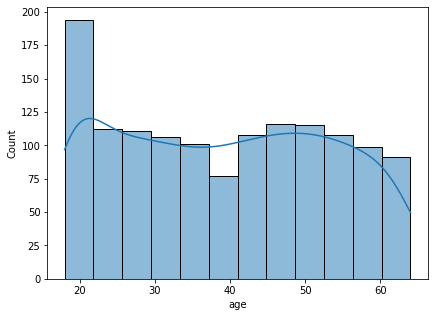

In [7]:
#checking the distribution of independent variables
#AGE
fig = plt.figure(figsize = (15,5))
plt.hist(df['age'],bins=20)
plt.subplot(1,2,2)
sns.histplot(df["age"], kde=True)

<AxesSubplot:xlabel='bmi', ylabel='Count'>

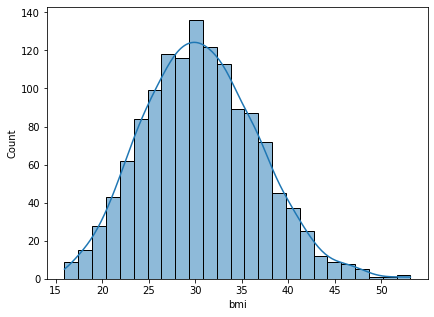

In [8]:
# BMI
fig = plt.figure(figsize = (15,5))
plt.hist(df['bmi'],bins=20)
plt.subplot(1,2,2)
sns.histplot(df["bmi"], kde=True)

<AxesSubplot:xlabel='children', ylabel='Count'>

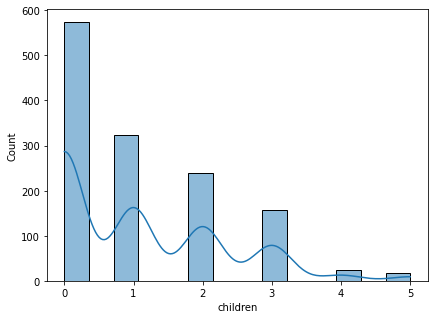

In [9]:
# Children 
fig = plt.figure(figsize = (15,5))
plt.hist(df['children'],bins=20)
plt.subplot(1,2,2)
sns.histplot(df["children"], kde=True)

<AxesSubplot:xlabel='charges', ylabel='Count'>

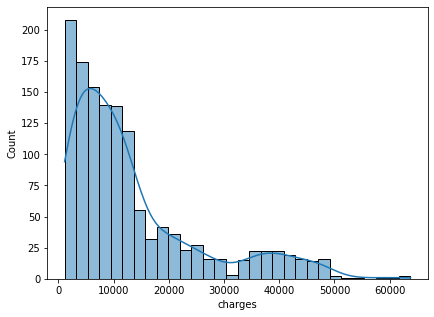

In [10]:
# Charges
fig = plt.figure(figsize = (15,5))
plt.subplot(1,2,2)
sns.histplot(df["charges"], kde=True)

## Which independent variables are useful to predict a target (dependent variable)? (Use at least three methods)
### Answer: The rank of independent variables:
### 1.Smoker 2. Children 3. region 4. sex 5. age 6.bmi

<AxesSubplot:>

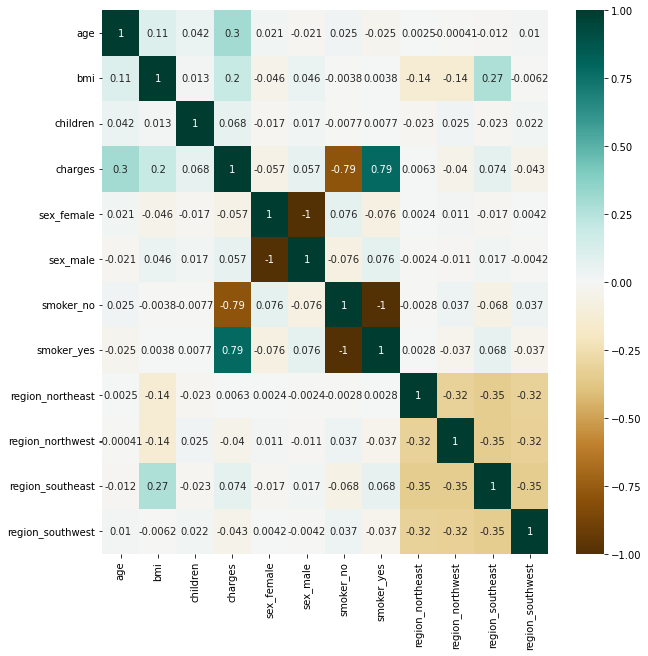

In [11]:
##the heat map of the correlation(The first method)
plt.figure(figsize=(10,10))
correlation_df = pd.get_dummies(df).corr()
sns.heatmap(correlation_df,cmap="BrBG",annot=True)

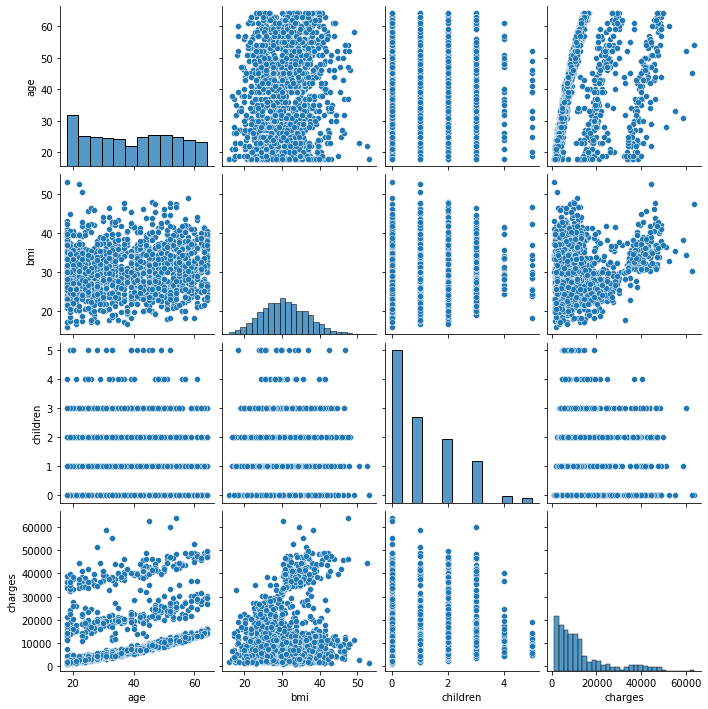

In [12]:
#pair plot to check the colinearity(The second method)
sns.pairplot(df)

In [13]:
#checking the correlation between all the features in the data(The third method)
df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


## Which independent variables have missing data? How much? 
### Answer: No missing data has found about independent variables.

In [14]:
# Print informations about dataset insurance
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Do the training and test sets have the same data?
### Answer: Yes, training and test sets have the same data.
##  In the predictor variables independent of all the other predictor variables?
### Answer: No, they are not independet of each other. There is multi - collinearity among lot of the independent variable which is shown by the correlation table and pairplot map

In [15]:
from sklearn.model_selection import  train_test_split

X = df[ ['age', 'sex',  'bmi', 'children','smoker', 'region']]

y = df['charges']

#Spliting data into Training 76.5%, Validation set 13.5% and Test set 10%

X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)

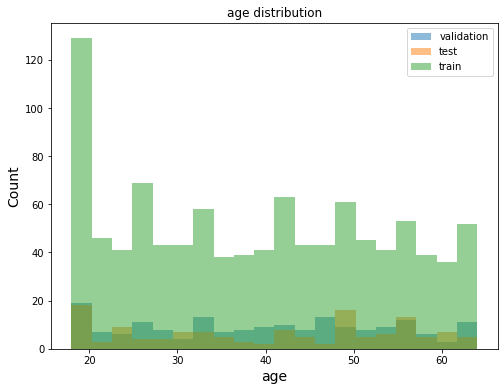

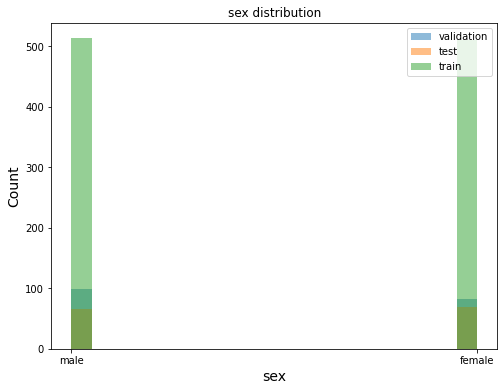

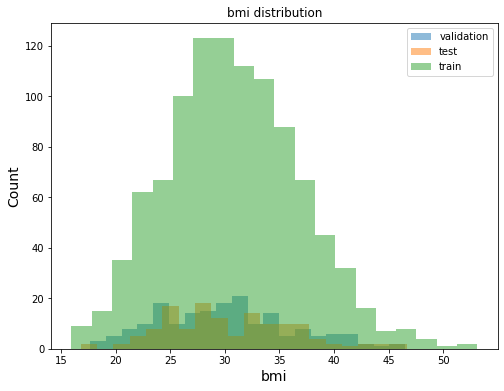

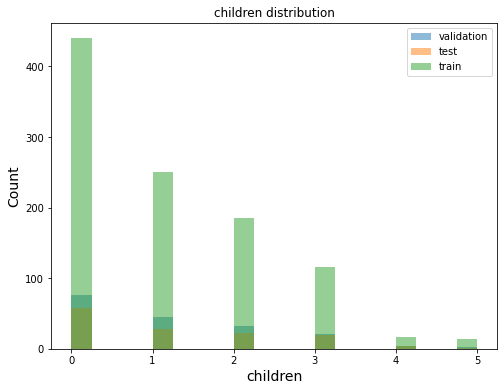

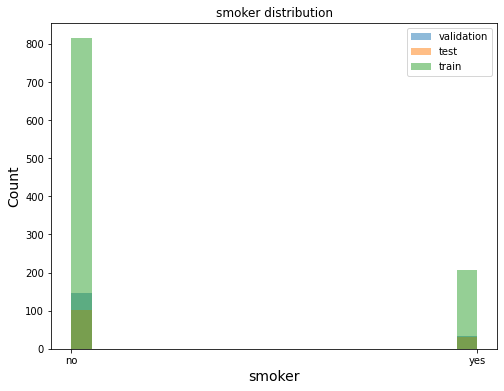

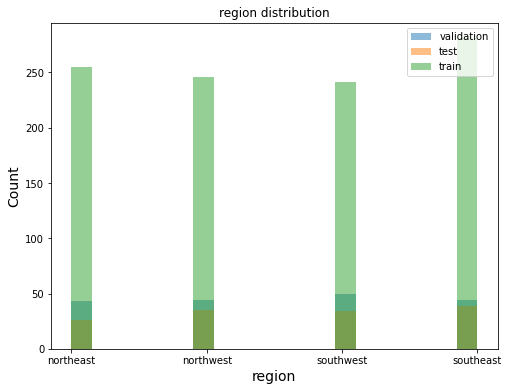

In [16]:
# Looking the data for test, training and validation set
X_test_plot = X_test[['age', 'sex',  'bmi', 'children','smoker', 'region']]

X_val_plot = X_val[['age', 'sex',  'bmi', 'children','smoker', 'region']]

X_train_plot = X_train[['age', 'sex',  'bmi', 'children','smoker', 'region']]

# Plotting the data to see the histogram
for c in X_test_plot.columns[:]:
  plt.figure(figsize=(8,6))
  plt.hist(X_val_plot[c], bins=20, alpha=0.5, label="validation")
  plt.hist(X_test_plot[c], bins=20, alpha=0.5, label="test")
  plt.hist(X_train_plot[c], bins=20, alpha=0.5, label="train")
  plt.xlabel(c, size=14)
  plt.ylabel("Count", size=14)
  plt.legend(loc='upper right')
  plt.title("{} distribution".format(c))
  plt.show()
 

## Linear Regression

In [17]:
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model

In [18]:
# Create a list of model names
models_names = ['LinearRegression']

In [19]:
# Create X and y matrix from dataset insurance_copy
X, y = preprocessing(df)

shape of X: (1337, 12)
shape of y: (1337,)


In [20]:
# Create train set and test set 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, 
    random_state=42, stratify=X['smoker']
)

In [21]:
# Create algorithm to compare
algorithms = [LinearRegression()]

In [22]:
def predict_charges(algorithm):
    model = algorithm
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred


In [23]:
# Predict charges with Linear Regression
# and save keys and values in a dictionnary
models_and_pred_charges = {}
for a, m in zip(algorithms, models_names):
    y_pred = predict_charges(a)
    models_and_pred_charges[m] = y_pred

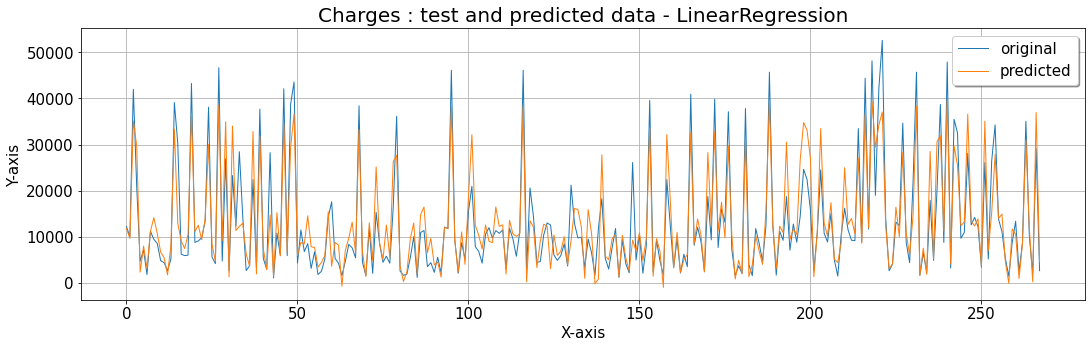

In [24]:
# Compare predictions with original
for k, v in zip(models_and_pred_charges.keys(), models_and_pred_charges.values()):
    compare_test_and_pred(v, k)

## Remove outliers and keep outliers (does if have an effect of the final predictive model)?
### Answer: No outliers found.

In [25]:
numeric_col = ['age','bmi','children']

<AxesSubplot:>

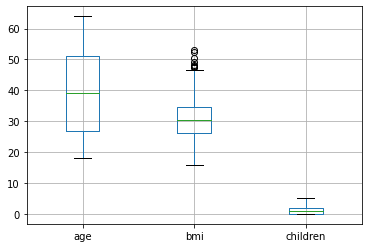

In [26]:
df.boxplot(numeric_col)

In [27]:
from collections import Counter
# Outlier detection 
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, bmi , children
Outliers_to_drop = detect_outliers(df,2,["age","bmi","children"])

In [28]:
df.loc[Outliers_to_drop] # Show the outliers rows

,age,sex,bmi,children,smoker,region,charges


## Remove 1%, 5%, and 10% of your data randomly and impute the values back using at least 3 imputation methods. How well did the methods recover the missing values?  That is remove some data, check the % error on residuals for numeric data and check for bias and variance of the error.
### Answer: According to the result of the residuals, bias and variance, the rank of imputation methods:
### 1. median 2. mean 3.previous value of the missed value

In [29]:
df_copy = df.copy()

In [30]:
# Remove 1% data randomly
def delete_10(col):
    col.iloc[col.sample(frac=0.01).index] = np.nan
    return col

df_copy.apply(delete_10, axis=0)

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3.0,no,northwest,10600.54830
1334,18.0,female,31.920,0.0,no,northeast,2205.98080
1335,18.0,female,36.850,0.0,no,southeast,1629.83350
1336,21.0,female,25.800,0.0,no,southwest,2007.94500


In [31]:
#Show removed data
df_copy[numeric_col].isnull().sum() / len(df)

age         0.009716
bmi         0.009716
children    0.009716
dtype: float64

In [32]:
#impute data by mean
df_copy['age'].fillna(df_copy['age'].mean(),inplace=True)
df_copy['bmi'].fillna(df_copy['bmi'].mean(),inplace=True)
df_copy['children'].fillna(df_copy['children'].mean(),inplace=True)

In [33]:
#show data information
df_copy[numeric_col].isnull().sum() / len(df)

age         0.0
bmi         0.0
children    0.0
dtype: float64

In [34]:
#check the % error on residuals for numeric data and check for bias and variance of the error
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import bias_variance_decomp
#separate into inputs and outputs
numeric_col = ['age','bmi','children']
data= df_copy[numeric_col].values
X, y= data[:, :-1], data[:, -1]
#split the data
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=1)
#define the model
model= LinearRegression()
#estimate bias and variance
mse,bias, var = bias_variance_decomp(model, X_train, y_train, X_test, y_test,loss='mse', num_rounds=200, random_seed=1)
#summarize results
print('RESUDUALS:%.3f' % mse)
print('Bias:%.3f' % bias)
print('Variance:%.3f' % var)

RESUDUALS:1.329
Bias:1.324
Variance:0.005


In [35]:
# Remove 1% data randomly
def delete_10(col):
    col.iloc[col.sample(frac=0.01).index] = np.nan
    return col

df_copy.apply(delete_10, axis=0)

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3.0,no,northwest,10600.54830
1334,18.0,female,31.920,0.0,no,northeast,2205.98080
1335,18.0,female,36.850,0.0,no,southeast,1629.83350
1336,21.0,female,25.800,0.0,no,southwest,2007.94500


In [36]:
#impute data by median
df_copy['age'].fillna(df_copy['age'].median(),inplace=True)
df_copy['bmi'].fillna(df_copy['bmi'].median(),inplace=True)
df_copy['children'].fillna(df_copy['children'].median(),inplace=True)

In [37]:
#check the % error on residuals for numeric data and check for bias and variance of the error
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import bias_variance_decomp
#separate into inputs and outputs
numeric_col = ['age','bmi','children']
data= df_copy[numeric_col].values
X, y= data[:, :-1], data[:, -1]
#split the data
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=1)
#define the model
model= LinearRegression()
#estimate bias and variance
mse,bias, var = bias_variance_decomp(model, X_train, y_train, X_test, y_test,loss='mse', num_rounds=200, random_seed=1)
#summarize results
print('RESUDUALS:%.3f' % mse)
print('Bias:%.3f' % bias)
print('Variance:%.3f' % var)

RESUDUALS:1.314
Bias:1.309
Variance:0.005


In [38]:
# Remove 1% data randomly
def delete_10(col):
    col.iloc[col.sample(frac=0.01).index] = np.nan
    return col

df_copy.apply(delete_10, axis=0)

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3.0,no,northwest,10600.54830
1334,18.0,female,31.920,0.0,no,northeast,2205.98080
1335,18.0,female,36.850,0.0,no,southeast,1629.83350
1336,21.0,female,25.800,0.0,no,southwest,2007.94500


In [39]:
#impute data by the previous value of missed data
df_copy['age'].fillna(method='ffill',inplace=True)
df_copy['bmi'].fillna(method='ffill',inplace=True)
df_copy['children'].fillna(method='ffill',inplace=True)

In [40]:
#check the % error on residuals for numeric data and check for bias and variance of the error
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import bias_variance_decomp
#separate into inputs and outputs
numeric_col = ['age','bmi','children']
data= df_copy[numeric_col].values
X, y= data[:, :-1], data[:, -1]
#split the data
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=1)
#define the model
model= LinearRegression()
#estimate bias and variance
mse,bias, var = bias_variance_decomp(model, X_train, y_train, X_test, y_test,loss='mse', num_rounds=200, random_seed=1)
#summarize results
print('RESUDUALS:%.3f' % mse)
print('Bias:%.3f' % bias)
print('Variance:%.3f' % var)

RESUDUALS:1.311
Bias:1.306
Variance:0.005


In [41]:
# Remove 5% data randomly
def delete_10(col):
    col.iloc[col.sample(frac=0.05).index] = np.nan
    return col

df_copy.apply(delete_10, axis=0)

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,NaN,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,NaN,33.000,3.0,no,NaN,4449.46200
3,33.0,male,22.705,NaN,no,NaN,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3.0,no,northwest,10600.54830
1334,18.0,female,31.920,0.0,NaN,northeast,2205.98080
1335,18.0,female,36.850,NaN,no,southeast,1629.83350
1336,21.0,female,25.800,0.0,no,southwest,2007.94500


In [42]:
#Show removed data
df_copy[numeric_col].isnull().sum() / len(df)

age         0.050075
bmi         0.050075
children    0.050075
dtype: float64

In [43]:
#impute data by mean
df_copy['age'].fillna(df_copy['age'].mean(),inplace=True)
df_copy['bmi'].fillna(df_copy['bmi'].mean(),inplace=True)
df_copy['children'].fillna(df_copy['children'].mean(),inplace=True)

In [44]:
#show data information
df_copy[numeric_col].isnull().sum() / len(df)

age         0.0
bmi         0.0
children    0.0
dtype: float64

In [45]:
# Remove 5% data randomly
def delete_10(col):
    col.iloc[col.sample(frac=0.05).index] = np.nan
    return col

df_copy.apply(delete_10, axis=0)

,age,sex,bmi,children,smoker,region,charges
0,NaN,female,27.900,1.095312,yes,southwest,16884.92400
1,18.0,male,33.770,1.000000,no,southeast,1725.55230
2,28.0,NaN,33.000,3.000000,no,NaN,4449.46200
3,33.0,male,22.705,1.095312,no,NaN,21984.47061
4,32.0,male,28.880,0.000000,no,NaN,3866.85520
...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3.000000,no,northwest,10600.54830
1334,18.0,female,31.920,0.000000,NaN,northeast,2205.98080
1335,18.0,female,36.850,1.095312,no,southeast,1629.83350
1336,21.0,female,25.800,0.000000,no,southwest,2007.94500


In [46]:
#impute data by median
df_copy['age'].fillna(df_copy['age'].median(),inplace=True)
df_copy['bmi'].fillna(df_copy['bmi'].median(),inplace=True)
df_copy['children'].fillna(df_copy['children'].median(),inplace=True)

In [47]:
#show data information
df_copy[numeric_col].isnull().sum() / len(df)

age         0.0
bmi         0.0
children    0.0
dtype: float64

In [48]:
#check the % error on residuals for numeric data and check for bias and variance of the error
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import bias_variance_decomp
#separate into inputs and outputs
numeric_col = ['age','bmi','children']
data= df_copy[numeric_col].values
X, y= data[:, :-1], data[:, -1]
#split the data
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=1)
#define the model
model= LinearRegression()
#estimate bias and variance
mse,bias, var = bias_variance_decomp(model, X_train, y_train, X_test, y_test,loss='mse', num_rounds=200, random_seed=1)
#summarize results
print('RESUDUALS:%.3f' % mse)
print('Bias:%.3f' % bias)
print('Variance:%.3f' % var)

RESUDUALS:1.168
Bias:1.163
Variance:0.004


In [49]:
# Remove 5% data randomly
def delete_10(col):
    col.iloc[col.sample(frac=0.05).index] = np.nan
    return col

df_copy.apply(delete_10, axis=0)

,age,sex,bmi,children,smoker,region,charges
0,39.252314,female,27.900,1.095312,yes,southwest,16884.9240
1,18.000000,male,33.770,1.000000,no,southeast,NaN
2,28.000000,NaN,33.000,3.000000,no,NaN,4449.4620
3,33.000000,male,22.705,1.095312,no,NaN,NaN
4,32.000000,male,28.880,0.000000,no,NaN,3866.8552
...,...,...,...,...,...,...,...
1333,50.000000,male,30.970,3.000000,no,NaN,10600.5483
1334,18.000000,female,31.920,0.000000,NaN,northeast,2205.9808
1335,NaN,female,36.850,1.095312,no,southeast,1629.8335
1336,21.000000,female,25.800,0.000000,no,southwest,2007.9450


In [50]:
#impute data by the previous value of missed data
df_copy['age'].fillna(method='ffill',inplace=True)
df_copy['bmi'].fillna(method='ffill',inplace=True)
df_copy['children'].fillna(method='ffill',inplace=True)

In [51]:
#check the % error on residuals for numeric data and check for bias and variance of the error
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import bias_variance_decomp
#separate into inputs and outputs
numeric_col = ['age','bmi','children']
data= df_copy[numeric_col].values
X, y= data[:, :-1], data[:, -1]
#split the data
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=1)
#define the model
model= LinearRegression()
#estimate bias and variance
mse,bias, var = bias_variance_decomp(model, X_train, y_train, X_test, y_test,loss='mse', num_rounds=200, random_seed=1)
#summarize results
print('RESUDUALS:%.3f' % mse)
print('Bias:%.3f' % bias)
print('Variance:%.3f' % var)

RESUDUALS:1.155
Bias:1.150
Variance:0.004


In [52]:
# Remove 10% data randomly
df_copy = df.copy()
def delete_10(col):
    col.iloc[col.sample(frac=0.1).index] = np.nan
    return col

df_copy.apply(delete_10, axis=0)

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,NaN
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,NaN,NaN,30.970,3.0,NaN,northwest,10600.54830
1334,NaN,female,31.920,0.0,no,northeast,2205.98080
1335,18.0,female,NaN,0.0,no,southeast,1629.83350
1336,NaN,female,25.800,0.0,no,southwest,2007.94500


In [53]:
#Show removed data
df_copy[numeric_col].isnull().sum() / len(df)

age         0.100149
bmi         0.100149
children    0.100149
dtype: float64

In [54]:
#impute data by mean
df_copy['age'].fillna(df_copy['age'].mean(),inplace=True)
df_copy['bmi'].fillna(df_copy['bmi'].mean(),inplace=True)
df_copy['children'].fillna(df_copy['children'].mean(),inplace=True)

In [55]:
#check the % error on residuals for numeric data and check for bias and variance of the error
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import bias_variance_decomp
#separate into inputs and outputs
numeric_col = ['age','bmi','children']
data= df_copy[numeric_col].values
X, y= data[:, :-1], data[:, -1]
#split the data
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=1)
#define the model
model= LinearRegression()
#estimate bias and variance
mse,bias, var = bias_variance_decomp(model, X_train, y_train, X_test, y_test,loss='mse', num_rounds=200, random_seed=1)
#summarize results
print('RESUDUALS:%.3f' % mse)
print('Bias:%.3f' % bias)
print('Variance:%.3f' % var)

RESUDUALS:1.187
Bias:1.183
Variance:0.005


In [56]:
# Remove 10% data randomly
df_copy = df.copy()
def delete_10(col):
    col.iloc[col.sample(frac=0.1).index] = np.nan
    return col

df_copy.apply(delete_10, axis=0)

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.90,0.0,yes,southwest,16884.92400
1,NaN,male,33.77,1.0,no,southeast,1725.55230
2,28.0,male,33.00,3.0,no,southeast,4449.46200
3,33.0,male,NaN,0.0,NaN,northwest,21984.47061
4,NaN,male,28.88,0.0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,NaN,male,30.97,3.0,no,northwest,10600.54830
1334,18.0,female,NaN,0.0,no,northeast,2205.98080
1335,18.0,NaN,36.85,0.0,no,southeast,1629.83350
1336,21.0,female,NaN,0.0,no,southwest,NaN


In [57]:
#impute data by median
df_copy['age'].fillna(df_copy['age'].median(),inplace=True)
df_copy['bmi'].fillna(df_copy['bmi'].median(),inplace=True)
df_copy['children'].fillna(df_copy['children'].median(),inplace=True)

In [58]:
#check the % error on residuals for numeric data and check for bias and variance of the error
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import bias_variance_decomp
#separate into inputs and outputs
numeric_col = ['age','bmi','children']
data= df_copy[numeric_col].values
X, y= data[:, :-1], data[:, -1]
#split the data
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=1)
#define the model
model= LinearRegression()
#estimate bias and variance
mse,bias, var = bias_variance_decomp(model, X_train, y_train, X_test, y_test,loss='mse', num_rounds=200, random_seed=1)
#summarize results
print('RESUDUALS:%.3f' % mse)
print('Bias:%.3f' % bias)
print('Variance:%.3f' % var)

RESUDUALS:1.242
Bias:1.238
Variance:0.005


In [59]:
# Remove 10% data randomly
df_copy = df.copy()
def delete_10(col):
    col.iloc[col.sample(frac=0.1).index] = np.nan
    return col

df_copy.apply(delete_10, axis=0)

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,NaN,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,NaN,28.880,0.0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50.0,male,30.970,NaN,no,northwest,10600.54830
1334,18.0,female,31.920,0.0,no,northeast,2205.98080
1335,18.0,female,36.850,0.0,no,southeast,1629.83350
1336,NaN,NaN,25.800,0.0,no,southwest,2007.94500


In [60]:
#impute data by the previous value of missed data
df_copy['age'].fillna(method='ffill',inplace=True)
df_copy['bmi'].fillna(method='ffill',inplace=True)
df_copy['children'].fillna(method='ffill',inplace=True)

In [61]:
#show data information
df_copy[numeric_col].isnull().sum() / len(df)

age         0.0
bmi         0.0
children    0.0
dtype: float64

In [62]:
#check the % error on residuals for numeric data and check for bias and variance of the error
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import bias_variance_decomp
#separate into inputs and outputs
numeric_col = ['age','bmi','children']
data= df_copy[numeric_col].values
X, y= data[:, :-1], data[:, -1]
#split the data
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=1)
#define the model
model= LinearRegression()
#estimate bias and variance
mse,bias, var = bias_variance_decomp(model, X_train, y_train, X_test, y_test,loss='mse', num_rounds=200, random_seed=1)
#summarize results
print('RESUDUALS:%.3f' % mse)
print('Bias:%.3f' % bias)
print('Variance:%.3f' % var)

RESUDUALS:1.472
Bias:1.467
Variance:0.005


## Public dataset
### https://www.kaggle.com/datasets/mirichoi0218/insurance
## Reference:
### https://github.com/aiskunks/Skunks_Skool/tree/main/INFO_6105/ML_Data_Cleaning_and_Feature_Selection/6105_ML_Data_Cleaning_and_Feature_Selection_Abalone_Example (Training and test dataset)
### https://www.kaggle.com/code/joachimcaron/eda-and-predicting-insurance-cost (LinearRegression)
### The remaining code was written independently.

Copyright <2022> <ShuangLiang>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), 
to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, 
and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. 
IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.